# SEI (Solid Electrolyte Interface) Builder

<div class="alert alert-block alert-info">
    <table style="border-collapse:collapse; vertical-align:top">
    <col style="width:35%; min-width:150px;"/>
    <col style="width:65%; min-width:200px;"/>
    <tfoot>
        <tr>
            <td style="border-right:2px solid #ffffff; min-width:300px">
                <a href="https://www.big-map.eu/">
                    <img style="width:12%; min-width:25px" src="img/logo-bigmap.png" alt="BIG MAP site" >
                </a>
                <a href="https://areeweb.polito.it/ricerca/small/">
                    <img style="width:50%; min-width:100px" src="img/logo-small.png" alt="SMALL site" >
                </a>
                <a href="https://www.polito.it/">
                    <img style="width:30%; min-width:60px" src="img/logo-polito.png" alt="POLITO site" >
                </a>
            </td>
            <td style="border-collapse:collapse;color:#0097a7; font-size:11pt; text-align:right; min-width:200px">
                <b>Autors:</b><br>            
                Paolo De Angelis (<a href="mailto:paolodeangelis@polito.it">paolodeangelis@polito.it</a>)<br>  
                Roberta Cappabianca (<a href="mailto:roberta.cappabianca@polito.it">roberta.cappabianca@polito.it</a>)<br>  
                Eliodoro Chiavazzo (<a href="mailto:eliodoro.chiavazzo@polito.it">eliodoro.chiavazzo@polito.it</a>)<br>  
                Pietro Asianri (<a href="mailto:pietro.asinari@polito.it">pietro.asinari@polito.it</a>)
            </td>
        </tr>
    </tfoot>
    </table>
</div>

---

**Base Idea**

Reconstruction of SEI by randomly positioning of monocrystal grains in mass proportion from the previous step and from a size distribution (from experiments?).

**Assumptions**
* SEI is made by packing monocrystal grains.
* The grain size follows a given size distribution.
* Each grain shape can be obtained by cutting the supercell with different crystal planes.
* By annealing the system, we will allow the atoms on the grain surfaces to form the "grain bonds."

![Sei builder sketch](img/sei_builder_sketch.png)

## Libraries

In [20]:
%load_ext autoreload
%autoreload 2
# TODO remove lines aboves

import importlib
import os
import pickle
import sys
from collections import deque

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from ase.lattice.cubic import DiamondFactory
from ase.lattice.hexagonal import HexagonalFactory
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from numpy.random import PCG64, Generator

from seibuilder import (  # get_bulk_atoms,
    from_d_to_grain,
    get_gcd_pedices,
    get_stable_crystal,
    random_sei_grains,
)
from seibuilder.packmol import PackmolStructure, packmol
from seibuilder.utils import makedir

plt.style.use("default")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-block alert-danger">
<b>⚠️ Danger:</b> if the previus <i>cell code</i> where we import all the useful libraries you get the 
following message

<code>
.../SEI_builder/seibuilder/mpinterfaces/__init__.py:35: UserWarning: mpint_config.yaml file not configured.
</code>

You have to get and store the Material Project API Key. Read the relative section in the README file or 
the documentation.
</div>

## Settings

In the **code cell** below, we set the main constants.

* `PACKMOL_BIN`: is the path to packmol binary
* `SEED`: seed number for the random generator
* `SEI_COMPONENTS_INFO`: is a `pandas.DataFrame` containing all the information about the inorganic salts 
    forming the SEI

In [21]:
PACKMOL_BIN = "./packmol/packmol"  # Optional, if packmol is bin folder is in the PATH you can set it as `None`
SEED = 42
np.array([24, 7, 4])  # [N molecules] LiF, Li2CO3, Li2O

NATOMS = 5000  # Number of atoms inside the numerical box
NATOMS_GRAIN = 700  # Max number of atoms of a single grain
CUTTING_PLANES = [  # List of Miller indices with all possible cutting surfaces to use to get an SEI grain
    (1, 0, 0),
    (1, 1, 0),
    (1, 1, 1),
    (1, 2, 0),
    (1, 3, 0),
    (1, 2, 1),
    (1, 3, 1),
]
SEI_COMPONENTS_INFO = pd.DataFrame(
    index=["LiF", "Li2CO3", "Li2O"],  # Empircal chemical formulat of the components (rows)
    columns=[  # name of each data (columns)
        "molar fraction",  # The cristals molar fraction
        "size distribution (mean)",  # The mean grain diameters
        "size distribution (std)",  # The std grain diameters
    ],
    data=[
        [24 / 35, 15.0, 3.0],  # LiF
        [7 / 35, 13.0, 3.0],  # Li2CO3
        [4 / 35, 10.0, 2.0],  # Li2O
    ],
)

# Outputs
PLOT_DIR = "out/plots"
makedir(PLOT_DIR)
CONF_DIR = "out/sei_conf"
makedir(CONF_DIR)

[W]: Folder out/plots already exist
[W]: Folder out/sei_conf already exist


showing the data for the SEI

In [3]:
SEI_COMPONENTS_INFO

,molar fraction,size distribution (mean),size distribution (std)
LiF,0.685714,15.0,3.0
Li2CO3,0.200000,13.0,3.0
Li2O,0.114286,10.0,2.0


## Get Salts

First thing first, we are querying the [Materials Project](https://materialsproject.org/) database to get a more stable(i.e., the one with minimum formation energy) crystal unit for each salt in the DataFrame `SEI_COMPONENTS_INFO`

In [4]:
unitcell_mp = {}
unitcell_ase = {}

for formula in SEI_COMPONENTS_INFO.index:
    uc_mp, uc_ase = get_stable_crystal(formula)
    unitcell_mp[formula] = uc_mp
    unitcell_ase[formula] = uc_ase

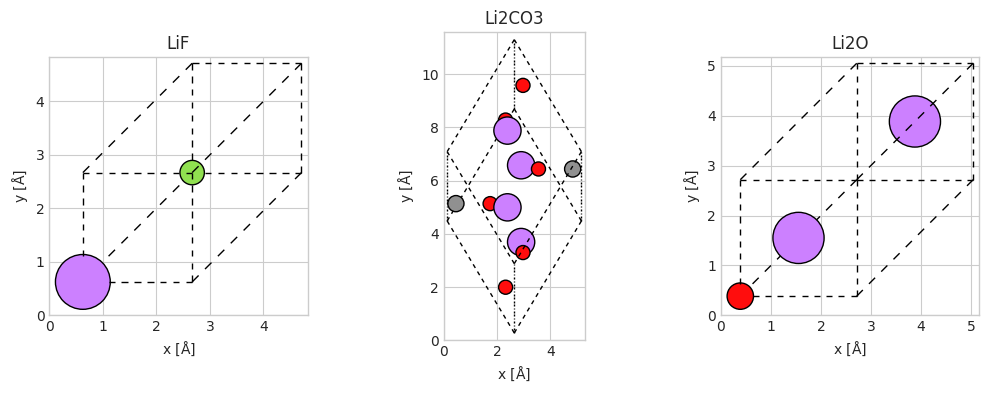

In [6]:
Nuc = len(unitcell_ase)
fig = plt.figure(figsize=[4 * min(Nuc, 3), 4 * np.floor(Nuc / 3)], dpi=100, facecolor="white")

with plt.style.context("seaborn-whitegrid"):
    spec = gridspec.GridSpec(ncols=min(Nuc, 3), nrows=int(np.floor(Nuc / 3)), figure=fig, wspace=0.3)
    ax = []
    for i, (formula, atoms) in enumerate(unitcell_ase.items()):
        ax.append(fig.add_subplot(spec[i]))
        plot_atoms(atoms, ax[-1], radii=0.4, rotation="0x,0y,0z")
        ax[-1].set_title(f"{formula}")
        ax[-1].set_xlabel(r"x [$\mathrm{\AA}$]")
        ax[-1].set_ylabel(r"y [$\mathrm{\AA}$]")

fig.savefig(os.path.join(PLOT_DIR, "1-crystals-unitcell.png"), dpi=300, bbox_inches="tight")

## Random sempling

### Set up sampling space

In [7]:
from functools import partial

pcg64 = PCG64(seed=SEED)  # Set random number generator (PCG 64) and random state seed
rg = Generator(pcg64)
rg.standard_normal()  # Since we do not know the experimental size distribution, we use a gues normal PDF


def grain_d(d_mean: float, d_std: float) -> float:
    """Get an SEI's grain size randomly from a gaussian distribution.

    This is an auxiliary function and can be replaced with a function that sample
    from an experimental data or different PDF.
    Args:
        d_mean (float): mean size grain size.
        d_std (float): grain size standard deviation.

    Returns:
        float: random sampled size.
    """
    d = rg.normal(loc=d_mean, scale=d_std, size=1)[0]
    return d


semplings_functions = []
d_mean = SEI_COMPONENTS_INFO["size distribution (mean)"]
d_std = SEI_COMPONENTS_INFO["size distribution (std)"]
for d_mean_, d_std_ in zip(d_mean, d_std):
    semplings_functions.append(partial(grain_d, d_mean_, d_std_))

### SEI's grains sampling

With the function `random_sei_grains`, we build all the grains (nanoparticles) forming the SEI using the Wulff construction. The sampling is constrained, forcing the final molar fraction and the total number of atoms.

Below are all the function inputs:

In [8]:
help(random_sei_grains)

Help on function random_sei_grains in module seibuilder.core.functions:

random_sei_grains(Natoms: int, species_unitcell: List[pymatgen.core.structure.Structure], species_fractions: list, random_sampler: List[Callable], species_fraction_tol: float = 0.005, Ngrains_max: int = None, report: str = None, cutting_planes: list = None, n_planes: int = 2, seed: int = None) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray, List[ase.atoms.Atoms]]
    Get the different grains knowing the size distribution, cutting planes, and molar fraction.
    
    The function random generates a grain knowing the crystal unit cell and the grain size distribution.
    The sampling is constrained to get the final number of atoms close to ``Natoms`` and to respect the
    molar fraction of each component (``species_fractions``).
    Args:
        Natomas (int): Max number of atoms to sample.
        species_unitcell (List[Structure]): list containing pymatgen.Structure objects that represent
  

In [22]:
species_unitcell = list(unitcell_mp.values())
species_fractions = SEI_COMPONENTS_INFO["molar fraction"]

out_species, out_d, out_vol, out_species_fraction, out_grains = random_sei_grains(
    NATOMS,
    species_unitcell,
    species_fractions,
    semplings_functions,
    species_fraction_tol=0.05,
    Ngrains_max=NATOMS_GRAIN,
    cutting_planes=CUTTING_PLANES,
    n_planes=2,
    seed=SEED,
)

[W]: [00:59:44 CEST] Was impossible build a grain particle (8) of specie Li1 F1 with target lenght 12.53 AA and volume 1029.19 AA^3 and surface [(1, 0, 0), (1, 3, 0)][1.         0.79720585]
[W]: [01:00:34 CEST] Was impossible build a grain particle (8) of specie Li1 F1 with target lenght 16.95 AA and volume 2550.61 AA^3 and surface [(1, 1, 0), (1, 3, 1)][1.         0.96515914]
[W]: [01:01:30 CEST] Was impossible build a grain particle (9) of specie Li1 F1 with target lenght 16.63 AA and volume 2407.87 AA^3 and surface [(1, 2, 0), (1, 0, 0)][0.95811395 1.        ]
[W]: [01:02:20 CEST] Was impossible build a grain particle (9) of specie Li1 F1 with target lenght 13.00 AA and volume 1151.27 AA^3 and surface [(1, 1, 0), (1, 2, 0)][1.        0.9678011]
[W]: [01:03:57 CEST] Grain particle 12 rejected since exceed the total numebr of atoms allow for specie Li1 F1                                                         
[W]: [01:05:37 CEST] Grain particle 28 rejected since exceed the total num

Store the results (as pickle)

In [12]:
with open(os.path.join(CONF_DIR, "0-grain_list.pkl"), "wb") as file_:
    pickle.dump([out_species, out_d, out_vol, out_species_fraction, out_grains], file_)

### Final results analisy

Load result from previus step

In [11]:
with open(os.path.join(CONF_DIR, "0-grain_list.pkl"), "rb") as file_:
    out_species, out_d, out_vol, out_species_fraction, out_grains = pickle.load(file_)

Plotting particle size theoretical and computed distribution

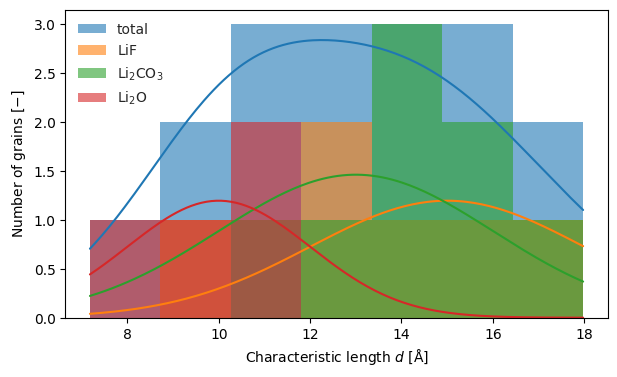

In [14]:
fig = plt.figure(figsize=[7, 4], dpi=100)
ax = fig.add_subplot(111)

labels = [r"$\mathrm{LiF}$", r"$\mathrm{Li_2CO_3}$", r"$\mathrm{Li_2O}$"]
bins = np.linspace(out_d.min(), out_d.max(), 8)
d_x = np.linspace(out_d.min(), out_d.max(), 200)

with plt.style.context("seaborn-whitegrid"):
    hist_d, _ = np.histogram(out_d, bins=bins, density=True)
    ax.bar(
        bins[:-1], np.round(hist_d * len(out_species)), width=bins[1] - bins[0], align="edge", label="total", alpha=0.6
    )
    tot_dist = np.zeros(len(d_x))
    for i in np.unique(out_species):
        tot_dist += stats.norm.pdf(d_x, d_mean[i], d_std[i]) * np.sum(out_species == i)
    ax.plot(d_x, tot_dist)

    for i in np.unique(out_species):
        hist_d, _ = np.histogram(out_d[out_species == i], bins=bins, density=True)
        ax.bar(
            bins[:-1],
            np.round(hist_d * np.sum(out_species == i)),
            width=bins[1] - bins[0],
            align="edge",
            label=labels[i],
            alpha=0.6,
        )
        ax.plot(d_x, stats.norm.pdf(d_x, d_mean[i], d_std[i]) * np.sum(out_species == i))

    ax.legend()
    ax.grid()
    ax.set_xlabel(r"Characteristic length $d$ [$\mathrm{\AA}$]")
    ax.set_ylabel("Number of grains [$-$]")
plt.show()
fig.savefig(os.path.join(PLOT_DIR, "2-grain_distributions.png"), bbox_inches="tight", dpi=300)

Plotting particle molar fractions

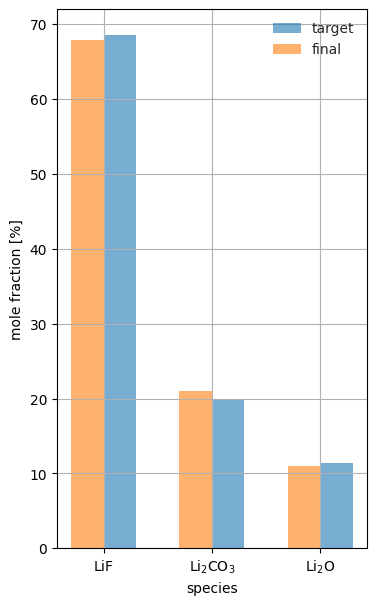

In [18]:
fig = plt.figure(figsize=[4, 7], dpi=100)
ax = fig.add_subplot(111)

labels = [r"$\mathrm{LiF}$", r"$\mathrm{Li_2CO_3}$", r"$\mathrm{Li_2O}$"]
x = np.arange(len(out_species_fraction))

with plt.style.context("seaborn-whitegrid"):
    ax.bar(x + 0.15, species_fractions / species_fractions.sum() * 100, width=0.3, label="target", alpha=0.6)
    ax.bar(x - 0.15, out_species_fraction * 100, width=0.3, label="final", alpha=0.6)

    ax.legend()
    ax.grid()
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel("species")
    ax.set_ylabel("mole fraction [%]")
plt.show()
fig.savefig(os.path.join(PLOT_DIR, "3-grain_mole_fraction.png"), bbox_inches="tight", dpi=300)

Plotting particle mass fractions

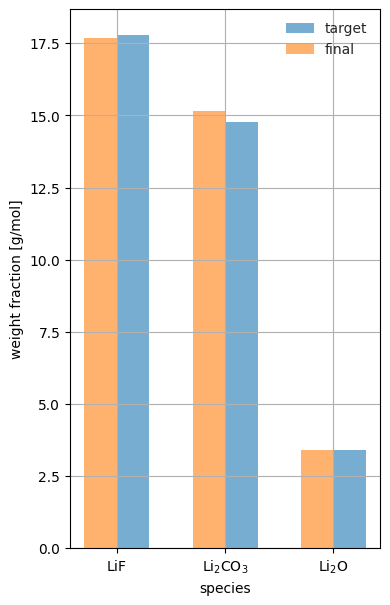

In [25]:
mass = np.array([np.sum(atoms.get_masses()) for atoms in unitcell_ase.values()])
molecules_in_unit_cell = np.array([get_gcd_pedices(system.formula) for system in species_unitcell])
mass = mass / molecules_in_unit_cell
atoms_in_unit_cell = np.array([len(system.sites) for system in species_unitcell])
out_atoms = np.zeros(len(np.unique(out_species)))

for i in np.unique(out_species):
    for particle in out_grains[out_species == i]:
        out_atoms[i] += len(particle)
        out_mass_fraction = out_atoms / atoms_in_unit_cell * molecules_in_unit_cell
out_mass_fraction = out_mass_fraction / out_mass_fraction.sum() * mass

fig = plt.figure(figsize=[4, 7], dpi=100)
ax = fig.add_subplot(111)

labels = [r"$\mathrm{LiF}$", r"$\mathrm{Li_2CO_3}$", r"$\mathrm{Li_2O}$"]
x = np.arange(len(out_species_fraction))

with plt.style.context("seaborn-whitegrid"):
    ax.bar(x + 0.15, species_fractions / species_fractions.sum() * mass, width=0.3, label="target", alpha=0.6)
    ax.bar(x - 0.15, out_mass_fraction, width=0.3, label="final", alpha=0.6)

    ax.legend()
    ax.grid()
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel("species")
    ax.set_ylabel("weight fraction [g/mol]")
plt.show()
fig.savefig(os.path.join(PLOT_DIR, "4-grain_weight_fraction.png"), bbox_inches="tight", dpi=300)

## Get additional characteristics

### Bonds

We esteem the bond in the system using Modified Shoemaker and Stevenson equation (https://doi.org/10.1016/0022-2860(85)85036-5)

In [15]:
out_grains_with_bonds = []

for clust_ in out_clust:
    # convert to System
    out_clust_with_bonds.append(System())
    out_clust_with_bonds[-1].from_atoms(clust_)
    # get bonds
    out_clust_with_bonds[-1].get_bonds(n_jobs=4, tol=0.1, ignore_molecules=True, verbose=2)

### Surface Atoms

In [16]:
for clust_ in out_clust_with_bonds:
    bulk_atoms, score = get_bulk_atoms(clust_, strategy="coordination", method="cutoff", threshold=0.5)
    clust_.info["bulk_atoms"] = bulk_atoms
    clust_.info["bulk_atoms_score"] = score

Visualize

In [17]:
from ase import Atoms

clust_ = out_clust_with_bonds[11]
positions = clust_.get_positions()
symbols = ["C" if x else "O" for x in clust_.info["bulk_atoms"]]
col_clust = Atoms(symbols=symbols, positions=positions)

v = view(col_clust, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(col_clust)
v.view.add_unitcell(col_clust)
v.view.display(gui=False)
v

Seve the results (as pickle)

In [18]:
with open(os.path.join("data", "1-grain_list_with_bonds.pkl"), "wb") as file_:
    cPickle.dump([out_species, out_d, out_vol, out_species_fraction, out_clust_with_bonds], file_)

## Pack all

### Load `Lammps wrapper`

In [2]:
# SMaLL's WorkStation
# module_stg = {"load": "lammps/29Oct2020_kokkos_python"}
# slurm_stg = {"--partition=": "small", "--time=": "240:00:00"}
# Maroconi100 HPC @ Cineca
# module_stg = {"purge":"",
#              "load": ["profile/chem-phys", "autoload lammps/3mar2020"]}
# slurm_stg = {"--partition=": "m100_usr_prod",
#             "--qos=": "m100_qos_dbg",
#             "--time=": "24:00:00",
#             "--mem=": "20000MB",
#             "--account=": "IscrB_MODLIBAT"}
# ARCHER2 HPC @ epcc.ed.ac.uk
module_stg = {"load": ["epcc-job-env", "lammps"]}
slurm_stg = {
    "--partition=": "standard",
    "--qos=": "standard",  # or short, or long
    "--time=": "24:00:00",
    "--account=": "pr1u1751",
}
pylmp.lammps.set_jobs_settings(slurm=slurm_stg, module=module_stg, verbose=2)

[I]: Read old settings file .lammps_wrapper/job_settings.json
[I]: JOB settings file saved in .lammps_wrapper/job_settings.json


True

In [3]:
lammps = pylmp.lammps.LAMMPS(lmp_cmd="lmp", mpi_cmd="srun", verbose=3)

[I]: Found configuration file .lammps_wrapper/job_settings.json in the hidden folder .lammps_wrapper
[W]: There is not the user info file .lammps_wrapper/user.json in the hidden folder .lammps_wrapper
[W]: Please use the function `lammps_wrapper.lammps.set_user()` to set-up the USER
[I]: User: pr1id026
[I]: Script save in run_None.sh
[I]: Script save in run_None.sh
[W]: Timeout!
[W]: Was impossible to run the cmd `mpirun -n 1 lmp -help`
[I]: Script save in run_None.sh
[I]: Script save in run_None.sh
[I]: image: lammps_wrapper/lammps_wrapper/img/logo.png
[I]: msg: <IPython.core.display.HTML object>


### Build Anode

#### $C_6$ Anode

In [5]:
class GrFactory(HexagonalFactory):  # make a new crsital object from the HexagonalFactory
    "A factory for creating Graphite lattices."
    xtal_name = "graphite"
    bravais_basis = [[0, 0, 0], [1.0 / 3.0, 2.0 / 3.0, 0], [1.0 / 3.0, 2.0 / 3.0, 0.5], [2.0 / 3.0, 1.0 / 3.0, 0.5]]

In [6]:
Gr = GrFactory()
a = 2.461  # [Å]
c = 6.708  # [Å]
Lx, Ly, Lz = [35.0, 35.0, 20.0]  # [Å]
Nx, Ny, Nz = [int(np.round(Lx / c)), int(np.round(Ly / a)), int(np.round(Lz / a / 3**0.5))]
GrAnode = Gr(
    latticeconstant={"a": 2.461, "c": 6.708},
    symbol="C",
    size=(Nx, Ny, Nz),
    directions=[[0, 0, 0, 1], [1, -2, 1, 0], [1, 0, -1, 0]],
    pbc=True,
)
GrAnode.info["name"] = "Anode"
GrAnode.cell

Cell([33.54, 34.454, 21.312885187135038])

In [7]:
v = view(GrAnode, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(GrAnode)
v.view.add_unitcell(GrAnode)
v.view.display(gui=False)
v

#### $SI$ Anode

In [8]:
Diamond = DiamondFactory()
a = 5.43  # [Å]
Nslab = 18
da_z = a / 4
Lx, Ly, Lz = [35.0, 35.0, 5 * a]  # [Å]
Nx, Ny, Nz = [int(np.round(Lx / a * 2**0.5)), int(np.round(Ly / a * 2**0.5)), int(np.round(Lz / a))]
# Nx, Ny, Nz = [9, 9, 5]
SiAnode = Diamond(
    latticeconstant=a, symbol="Si", size=(Nx, Ny, Nz), directions=[[1, 1, 0], [-1, 1, 0], [0, 0, 1]], pbc=True
)
SiAnode.info["name"] = "Anode"
SiAnode.cell

Cell([34.55630839658657, 34.55630839658657, 27.15])

In [9]:
v = view(SiAnode, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(SiAnode)
v.view.add_unitcell(SiAnode)
v.view.display(gui=False)
v

### Pack SEI grains

In [10]:
# Choose a Anode
ANODE = SiAnode  # or GrAnode

In [17]:
porosity = 3
tot_vol = out_vol.sum() * (1 + porosity)
lc, wc, hc = ANODE.get_cell().diagonal()  # [Å]
clearance = 4  # [Å]
box = [lc, wc, tot_vol / (lc - clearance) / (wc - clearance) + clearance]
box

[34.55630839658657, 34.55630839658657, 72.38153131148434]

In [18]:
tolerance = 2.5
SEI_box = packmol(
    [
        PackmolStructure(
            cluster,
            number=1,
            instructions=[
                "inside box {:.16f} {:.16f} {:.16f} {:.16f} {:.16f} {:.16f}".format(
                    clearance / 2,
                    clearance / 2,
                    clearance / 2,
                    box[0] - clearance / 2,
                    box[1] - clearance / 2,
                    box[2] - clearance / 2,
                )
            ],
        )
        for cluster in out_clust
    ],
    packmol_bin=PACKMOL_BIN,
    verbose=2,
    n_lines=20,
    cell=box,
    tolerance=tolerance,
    nloop=100,
    seed=SEED,  # maxit=50,#, maxit=100,  cell=box_size,
)

[I]: [14:56:20 BST]               Please cite this work if Packmol was useful: 
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST]            L. Martinez, R. Andrade, E. G. Birgin, J. M. Martinez, 
[I]: [14:56:20 BST]          PACKMOL: A package for building initial configurations for
[I]: [14:56:20 BST]                    molecular dynamics simulations. 
[I]: [14:56:20 BST]           Journal of Computational Chemistry, 30:2157-2164,2009.
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST] ################################################################################
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST]   Solution written to file: output.xyz
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST] --------------------------------------------------------------------------------
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST]    Running time:    3.30092478      seconds. 
[I]: [14:56:20 BST] 
[I]: [14:56:20 BST] --------------------------------------------------------------------------------
[I]: [14:56:20 BST] 
[I]: [14:56:2

In [20]:
v = view(SEI_box, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(SEI_box)
v.view.add_unitcell(SEI_box)
v.view.display(gui=False)
v

#### Compute bonds

We esteem the bond in the system using Modified Shoemaker and Stevenson equation (https://doi.org/10.1016/0022-2860(85)85036-5)

In [87]:
SEI_box.get_bonds(n_jobs=4, tol=0.1, verbose=2)

In [88]:
bond_matrix = SEI_box.get_bond_matrix()

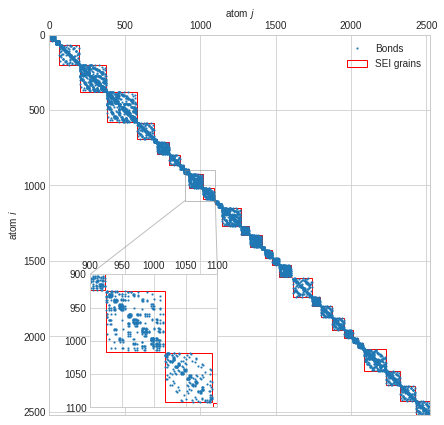

In [89]:
fig4 = plt.figure(figsize=[7, 7])
ax = fig4.add_subplot(111)
ax_zoom = ax.inset_axes([0.1, 0.02, 0.35, 0.35])
ax.spy(bond_matrix, markersize=1, label="Bonds")
ax_zoom.spy(bond_matrix, markersize=1)
# add grains border:
for atoms_list in SEI_box.molecules_index:
    i_min = np.min(atoms_list)
    i_max = np.max(atoms_list)
    square = plt.Rectangle((i_min, i_min), i_max - i_min, i_max - i_min, fc="none", ec="red")
    ax.add_patch(square)
    square = plt.Rectangle((i_min, i_min), i_max - i_min, i_max - i_min, fc="none", ec="red")
    ax_zoom.add_patch(square)
ax_zoom.set_ylim([1100, 900])
ax_zoom.set_xlim([900, 1100])
ax.indicate_inset_zoom(ax_zoom)
handles, labels = ax.get_legend_handles_labels()
handles[-1] = plt.Rectangle((0, 0), 0, 0, fc="none", ec="red")
labels[-1] = "SEI grains"
ax.legend(handles, labels)
ax.set_xlabel("atom $j$")
ax.xaxis.set_label_position("top")
ax.set_ylabel("atom $i$")
plt.show()
fig4.savefig(os.path.join("plots", "fig4-SEI_initial_configuration_bond-matrix.png"), bbox_inches="tight", dpi=300)

Save the graphite ans SEI strucure before any simulation

In [90]:
SEI_box.save(os.path.join("data", "1-SEI_initial_comf.pkl"))

## Compacting

Reload the initial configuration

In [2]:
SEI_box = System()
SEI_box.load(os.path.join("data", "1-SEI_initial_comf.pkl"))

### Load `Lammps wrapper`

In [42]:
# SMaLL's WorkStation
# module_stg = {"load": "lammps/29Oct2020_kokkos_python"}
# slurm_stg = {"--partition=": "small",     "--time=": "240:00:00"}
# Cineca HPC
module_stg = {"purge": "", "load": ["profile/chem-phys", "autoload lammps/3mar2020"]}
slurm_stg = {
    "--partition=": "m100_usr_prod",
    "--qos=": "m100_qos_dbg",
    "--time=": "2:00:00",
    "--mem=": "10000MB",
    "--account=": "IscrB_MODLIBAT",
}
pylmp.lammps.set_jobs_settings(slurm=slurm_stg, module=module_stg, verbose=2)

[I]: Read old settings file .lammps_wrapper/job_settings.json
[I]: JOB settings file saved in .lammps_wrapper/job_settings.json


True

In [44]:
lammps = pylmp.lammps.LAMMPS(lmp_cmd="lmp_mpi", mpi_cmd="mpirun", verbose=2)

[I]: Found configuration file .lammps_wrapper/job_settings.json in the hidden folder .lammps_wrapper
[I]: Found user info file .lammps_wrapper/user.json in the hidden folder .lammps_wrapper
[I]: User: pdeangel (paolo.deangelis@polito.it)
[I]: Script save in run_None.sh
[I]: Script save in run_None.sh


### Load Reax FF

Load Reax Force Fiels

In [26]:
reaxff = pylmp.ff.ReaxFF()
reaxff(os.path.join("data", "ffield.reax"))
# Add ReaxFF info
reaxff.ff_authors = ["Sang Soo Han"]
reaxff.ff_year = "2015"
reaxff.ff_doi = "http://battery.vfab.org/wiki/index.php/Anode_Materials_Design_Lab#Interatomic_Potential"
reaxff

--- ReaxFF C/H/O/Si/Al/Li/F/P/B ------------------------------------------------
    * 39 General Parameters:	 object.general.parm < pandas.DataFrame >
                         	 object.general.info < dict >
    * 9 Atoms X 32 Parameters:	 object.atoms.parm < pandas.DataFrame >
                         	 object.atoms.info < dict >
    * 38 Bonds X 16 Parameters:	 object.bonds.parm < pandas.DataFrame >
                         	 object.bonds.info < dict >
    * 29 VanDerWaals X 6 Parameters:	 object.vanderwaals.parm < pandas.DataFrame >
                         	 object.vanderwaals.info < dict >
    * 83 Angles X 7 Parameters:	 object.angles.parm < pandas.DataFrame >
                         	 object.angles.info < dict >
    * 50 Torsions X 7 Parameters:	 object.torsions.parm < pandas.DataFrame >
                         	 object.torsions.info < dict >
    * 2 HBonds X 4 Parameters:	 object.hbonds.parm < pandas.DataFrame >
                         	 object.hbonds.info < dict >
---------

Open a project

In [45]:
lammps.open_project(working_dir="simulations", project_name="SEI_builder", verbose=0)
project = lammps.projects[-1]
print(project)

[I]: Project Loaded       ████████████████████████████████████████████████████████████████████████ 100.0%
--- PROJECT --------------------------------------------------------------------
 Name:              SEI_builder
 Working Directory: simulations
 UUID:              50998144-b937-4cf1-9045-18ba90eb77bc
 Date:              26/04/2021 21:03:07 
 Simulations:       1
--------------------------------------------------------------------------------


### Energy minimization

In [10]:
# Uncomet if you not have the simulation in the folder
# project.make_simulation(working_dir=os.path.join(project.working_dir, 'compacting', 'EM'),
#                         simulation_name='Compacting/EM', verbose=2)

[I]: Folder /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting maked
[I]: Folder /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM maked
[I]: Simulation metadata updated
[I]: Simulation successfully created
[I]: Project metadata saved in simulations/project_metadata.json
[I]: Simulation successfully created!
[I]: Call `Simulation` method `Simulation.checklist()` to a get the next step before to run the it


Simulation object uuid:a2550950-d689-42d8-9771-29c5591b0d7b at 0x7fff490e2370

In [12]:
project.show()

TREE                          ID  UUID                                    INFO                      
----------------------------------------------------------------------------------------------------
Project: SEI_builder (1 simulations)
└──Compacting                                                                                       
    └──EM                     0   a2550950-d689-42d8-9771-29c5591b0d7b    NR (NO_READY)             



In [46]:
em_simulation = project.get_simulation(name="Compacting/EM")[0]

What we have to do:

In [17]:
em_simulation.check_list()

  ☑	Create simulation and its metadata.
  ☐	Add Simulation System:
   	Create and load the system with the `Simulation` class method `add_input` (`Simulation.add_input()) e.g.:
   		•  From a LAMMPS formatted file:
   		   >>> simulation.add_input(system='/Path/to/system_file.in')
   		•  From using ASE Atoms Object and the right Force Field Object:
   		   >>> mol = ase.atoms(...)
   		   >>> reaxff = lammps_wrapper.ff.ReaxFF(...)
   		   >>> simulation.add_input(system=mol, ff=reaxff))
  ☐	Add LAMMPS input script:
   	Create or load the LAMMPS script with class method `add_inputs` (`Simulation.add_inputs()) e.g.:
   		•  From a file:
   		   >>> simulation.add_input(input_script='/Path/to/input_file.in')
   		•  From using a dictionary with the parameters:
   		   >>> parameters = dict(units='real', atom_style='charge'
   		                         read_data=data_file_path, ...)
   		   >>> simulation.add_input(parameters=parameters)
  ☐	(Optional) Other inputs file:
   	Add file wit

**ADD**: Input data file and reaxff

In [19]:
em_simulation.add_input(system=SEI_box, ff=reaxff, atom_style="full", verbose=1)

[I]: User: pdeangel (paolo.deangelis@polito.it)
[I]: LAMMPS input data file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system 
[I]: LAMMPS input data file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system 
[I]: System LAMMPS input write in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system
[I]: Saved System python object in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system.pkl
[I]: Saved System python object in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/data.system.pkl
[I]: ReaxFF input file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/ff.forcefield 
[I]: ReaxFF (Reactive Force Field) (Force Field) saved in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/ff.forcefield
[I]: Simulation metad

**ADD**: Input script

In [57]:
from simulation_settings import default_em

parameters_em = default_em.copy()
parameters_em.update(
    dict(
        read_data=em_simulation.files["input_system"],
        pair_coeff="* * {} {}".format("ff.forcefield", " ".join(reaxff.elements)),
        minimize="0.0 50 10000 3000",
    )
)
em_simulation.add_input(parameters=parameters_em, verbose=2)

[I]: control file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/control.pair_style 
[W]: The following LAMMPS input commands will write in input file, but are not implemented yet
[W]: into the python wrapper:
[I]: LAMMPS input file save in /m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/in.simulation
[I]: log output style = `step temp pe etotal press vol fmax fnorm`
[I]: Simulation steps 10000 with a timestep None
[I]: Simulation metadata updated
[I]: Simulation metadata updated


In [29]:
em_simulation.check_list()

  ☑	Create simulation and its metadata.
  ☑	Add Simulation System:
   	Create and load the system with the `Simulation` class method `add_input` (`Simulation.add_input()) e.g.:
   		•  From a LAMMPS formatted file:
   		   >>> simulation.add_input(system='/Path/to/system_file.in')
   		•  From using ASE Atoms Object and the right Force Field Object:
   		   >>> mol = ase.atoms(...)
   		   >>> reaxff = lammps_wrapper.ff.ReaxFF(...)
   		   >>> simulation.add_input(system=mol, ff=reaxff))
  ☑	Add LAMMPS input script:
   	Create or load the LAMMPS script with class method `add_inputs` (`Simulation.add_inputs()) e.g.:
   		•  From a file:
   		   >>> simulation.add_input(input_script='/Path/to/input_file.in')
   		•  From using a dictionary with the parameters:
   		   >>> parameters = dict(units='real', atom_style='charge'
   		                         read_data=data_file_path, ...)
   		   >>> simulation.add_input(parameters=parameters)
  ☐	(Optional) Other inputs file:
   	Add file wit

In [58]:
em_simulation.run(
    mpi=128, omp=1, gpus=None, nodes=1, ntasks_per_node=128, cpus_per_task=None, follow=False, plot=False, verbose=1
)

In [1]:
128 / 2

64.0

In [59]:
em_simulation.show(plot=True, verbose=2, ypos=["etotal", "fnorm"], plot_window=100)

[I]: [21:40:24 CEST] Job 2931157 is RUNNING                                                              
[I]: I cannot find the actual step by looking at output file (/m100_work/IscrB_MODLIBAT/pdeangel/BATTERY/SEI_builder/simulations/compacting/EM/output-Compacting_EM-2931157.out)


FloatProgress(value=0.0, bar_style='info', description=' 0.00%', layout=Layout(width='900px'))

[I]: [21:54:29 CEST] Simulation `Compacting/EM` COMPLETED!


load results

In [79]:
out = reaxff.read_and_convert_dump(
    os.path.join(simulation.working_dir, simulation.files["output_dump"]), index=-1, ncores=12
)
out.set_pbc(True)
# Store in a System(Atoms) object with the moleculicense
SEI_em = System()
SEI_em.from_atoms(out)
SEI_em.set_molecules(SEI_box.molecules_index, molecule_names=SEI_box.molecules_name)

NameError: name 'simulation' is not defined

In [ ]:
v = view(SEI_em, viewer="ngl")
v.view.clear()
v.view.add_ball_and_stick(SEI_em)
v.view.add_unitcell(SEI_em)
v.view.display(gui=True)
v

Save the graphite ans SEI strucure after energy minimization

In [12]:
SEI_em.save(os.path.join("data", "2-SEI_energy_minimization.pkl"))